# --- Day 24: Air Duct Spelunking ---

You've finally met your match; the doors that provide access to the roof are locked tight, and all of the controls and related electronics are inaccessible. You simply can't reach them.

The robot that cleans the air ducts, however, can.

It's not a very fast little robot, but you reconfigure it to be able to interface with some of the exposed wires that have been routed through the HVAC system. If you can direct it to each of those locations, you should be able to bypass the security controls.

You extract the duct layout for this area from some blueprints you acquired and create a map with the relevant locations marked (your puzzle input). 0 is your current location, from which the cleaning robot embarks; the other numbers are (in no particular order) the locations the robot needs to visit at least once each. Walls are marked as #, and open passages are marked as .. Numbers behave like open passages.

For example, suppose you have a map like the following:

```
###########
#0.1.....2#
#.#######.#
#4.......3#
###########
```

To reach all of the points of interest as quickly as possible, you would have the robot take the following path:

- 0 to 4 (2 steps)
- 4 to 1 (4 steps; it can't move diagonally)
- 1 to 2 (6 steps)
- 2 to 3 (2 steps)

Since the robot isn't very fast, you need to find it the shortest route. This path is the fewest steps (in the above example, a total of 14) required to start at 0 and then visit every other location at least once.

Given your actual map, and **starting from location 0, what is the fewest number of steps required to visit every non-0 number marked on the map at least once?**

In [76]:
with open(f'inputs/24.txt') as f:
    puzzle_input = f.read().strip().split("\n")
puzzle_input[:3]

['#######################################################################################################################################################################################',
 '#.....................#.....#.#.......#.......#...#.....#.#...#.........#...........#...#.........#...#...#...#...#.........#.#.....#.........#.#.#.....#.....#.....#.#.#.............#',
 '#.#.###.#.###.#.###.#.#.###.#.###.#########.#.#####.#####.#.###.#.#.#.#.###.#.###.#.#.#.#.###.#.#.#.#.###.#.#.#.#.###.#.#.#.#.#.#.#.#.###.#.#.#.#.#.#####.###.#.#.#.#.#.###.#.#.#.#.#.#']

First up, making this into a numpy grid to make it easier to handle:

In [50]:
import numpy as np

def convert_to_grid(s):
    """takes in a list of strings and returns a 2d grid representation"""
    rows = [np.array([c for c in row], dtype="U") for row in s]
    return np.array(rows, dtype="U")

grid = convert_to_grid(puzzle_input)
print(f"Grid shape: {grid.shape}")
grid[0:5,0:10]

Grid shape: (37, 183)


array([['#', '#', '#', '#', '#', '#', '#', '#', '#', '#'],
       ['#', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
       ['#', '.', '#', '.', '#', '#', '#', '.', '#', '.'],
       ['#', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
       ['#', '.', '#', '#', '#', '.', '#', '.', '#', '#']], dtype='<U4')

Now to eyeball the grid more picture like, first up I'm making a list of positions of all the numbers in the grid:

In [242]:
def get_num_positions(grid=grid):
    """takes in grid with nums and returns the positions of the numbers"""
    num_positions = []
    for i in range(0, 10000):
        ix = np.isin(grid, str(i))
        if np.any(ix):
            num_positions.append(np.where(ix))
        else:
            break
    return num_positions

num_positions = get_num_positions()
num_positions

[(array([11]), array([149])),
 (array([5]), array([7])),
 (array([3]), array([149])),
 (array([17]), array([3])),
 (array([35]), array([137])),
 (array([27]), array([143])),
 (array([27]), array([27])),
 (array([17]), array([171]))]

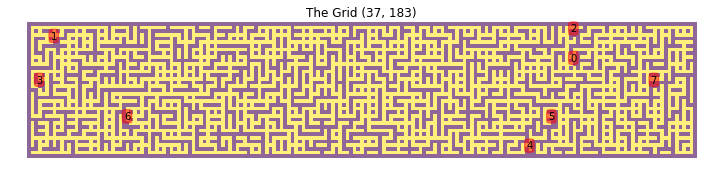

In [209]:
import matplotlib.pyplot as plt

def plot_grid(grid=grid, paths=None):
    """takes in a pattern as a string and plots it"""
    
    # first, draw the grid
    binary_grid = [c == "." for c in [row for row in grid]]
    plt.figure(figsize=(12,8))
    plt.imshow(binary_grid, alpha=0.6)
    plt.title(f"The Grid {grid.shape}")
    plt.axis('off')
    
    #labelling the numbers
    num_positions = get_num_positions(grid)
    box_style = dict(fc="red", ec="r", lw=1, alpha=0.5, boxstyle="round4,pad=0.2")
    for i, pos in enumerate(num_positions):
        y,x = pos
        plt.annotate(f"{i}", xy=(x-1,y-1), bbox=box_style)
    
    if paths:
        for path in paths:
            xx, yy = zip(*path)
            plt.plot(yy, xx, linewidth=3, label="Testing Path")
    
    plt.show()
    
plot_grid(grid)

Now since this is a grid, we might need manhatten distance b/w points:

In [262]:
def manhatten_distance(p, p2):
    return abs(p[0] - p2[0]) + abs(p[1] - p2[1])

assert(manhatten_distance(num_positions[0], num_positions[1]) == 148)

now to implement a BFS search to go from one num to the other.

In [263]:
from collections import deque, defaultdict

def solve(start=num_positions[0], destination=num_positions[2]):
    """takes in a start state and returns first path which reaches destination"""
    moves=((0,-1), (0,1),(-1,0), (1,0)) # possible moves for a 4 way grid
    
    stack = deque() # the paths to process
    stack.append([start])

    paths = [] # tracking all possible valid paths
    
    path = stack.popleft()
    print("Starting at node", start, "searching for", destination)
    
    i = 0 # counter to be able to print out whats going on once in a while
    while path[-1] != destination:
        if not path in paths: 
            cur_x, cur_y = path[-1]
            for node in [(cur_x+i, cur_y+j) for i,j in moves]:
                new_x, new_y = node
                if grid[new_x, new_y] != "#" and node not in path:
                    new_path = path[:]
                    new_path.append(node)
                    stack.append(new_path) # add all new unseen states to the stack
            paths.append(path) # have now processed this path
            
        try:
            path = stack.popleft()
        except:
            print(f"Error, the stack is empty at loop {i}")
            return paths
        
        i+=1
        if i % 10000 == 0:
            print(f"step {i:7,d}, looking at node {path[-1]} in a path of len {len(path)}")
    
    print("----"*12)
    print(f"It took {len(path)-1} steps from {start} node to the {destination} in a path of length {len(path)}")
    return path

path = solve()

Starting at node (array([11]), array([149])) searching for (array([3]), array([149]))
------------------------------------------------
It took 12 steps from (array([11]), array([149])) node to the (array([3]), array([149])) in a path of length 13


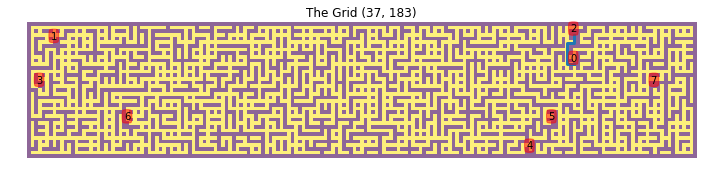

In [235]:
plot_grid(paths=[path])

In [264]:
solve(num_positions[2], num_positions[7])

Starting at node (array([3]), array([149])) searching for (array([17]), array([171]))
step  10,000, looking at node (array([12]), array([155])) in a path of len 36
step  20,000, looking at node (array([3]), array([155])) in a path of len 39
step  30,000, looking at node (array([7]), array([133])) in a path of len 41
step  40,000, looking at node (array([4]), array([163])) in a path of len 42
step  50,000, looking at node (array([1]), array([157])) in a path of len 43
step  60,000, looking at node (array([18]), array([163])) in a path of len 44
step  70,000, looking at node (array([5]), array([167])) in a path of len 45
step  80,000, looking at node (array([16]), array([131])) in a path of len 46
step  90,000, looking at node (array([17]), array([144])) in a path of len 46
step 100,000, looking at node (array([21]), array([158])) in a path of len 46
step 110,000, looking at node (array([7]), array([143])) in a path of len 47
step 120,000, looking at node (array([3]), array([139])) in a 

[(array([3]), array([149])),
 (array([4]), array([149])),
 (array([5]), array([149])),
 (array([5]), array([148])),
 (array([5]), array([147])),
 (array([6]), array([147])),
 (array([7]), array([147])),
 (array([8]), array([147])),
 (array([9]), array([147])),
 (array([9]), array([148])),
 (array([9]), array([149])),
 (array([10]), array([149])),
 (array([11]), array([149])),
 (array([12]), array([149])),
 (array([13]), array([149])),
 (array([13]), array([150])),
 (array([13]), array([151])),
 (array([13]), array([152])),
 (array([13]), array([153])),
 (array([13]), array([154])),
 (array([13]), array([155])),
 (array([13]), array([156])),
 (array([13]), array([157])),
 (array([14]), array([157])),
 (array([15]), array([157])),
 (array([16]), array([157])),
 (array([17]), array([157])),
 (array([17]), array([158])),
 (array([17]), array([159])),
 (array([17]), array([160])),
 (array([17]), array([161])),
 (array([18]), array([161])),
 (array([19]), array([161])),
 (array([20]), array(

so I should generate the paths from all possible permuations of the 8 points, then use that to calculate the shortest path which connects all 8 points. 

so looking at the grid positions of the numbers on the grid:

In [220]:
p = get_num_positions() # the positions of the numbers, with the first being 0
p

[(array([11]), array([149])),
 (array([5]), array([7])),
 (array([3]), array([149])),
 (array([17]), array([3])),
 (array([35]), array([137])),
 (array([27]), array([143])),
 (array([27]), array([27])),
 (array([17]), array([171]))]

Now to make a list of pairs:

In [236]:
from itertools import permutations
pairs = [x for x in permutations(num_positions, 2)]

Making a list of paths b/w each pair:

In [247]:
pair_paths = [solve(*pair) for pair in pairs]

Starting at node (array([11]), array([149])) searching for (array([5]), array([7]))
step  10,000, looking at node (array([11]), array([158])) in a path of len 28
step  20,000, looking at node (array([15]), array([140])) in a path of len 32
step  30,000, looking at node (array([15]), array([133])) in a path of len 33
step  40,000, looking at node (array([25]), array([150])) in a path of len 34
step  50,000, looking at node (array([25]), array([162])) in a path of len 36
step  60,000, looking at node (array([1]), array([160])) in a path of len 36
step  70,000, looking at node (array([7]), array([165])) in a path of len 37
step  80,000, looking at node (array([14]), array([137])) in a path of len 38
step  90,000, looking at node (array([17]), array([128])) in a path of len 38
step 100,000, looking at node (array([9]), array([169])) in a path of len 39
step 110,000, looking at node (array([1]), array([161])) in a path of len 39
step 120,000, looking at node (array([10]), array([149])) in a

KeyboardInterrupt: 

Now to look at this list and figure out the shortest path which contains all eight points: